In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [25]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
from vectorbt.timeseries import TimeSeries
from vectorbt.signals import Signals
from vectorbt.strategy import MA, TrailingStop
from vectorbt.positions import Positions
from vectorbt.portfolio import Portfolio

In [27]:
def download_bitcoin_history():
    from bs4 import BeautifulSoup
    import requests
    
    # Download data
    start_date = datetime(2013, 4, 28).strftime('%Y%m%d') # Bitcoin is the oldest
    end_date = datetime.today().strftime('%Y%m%d')
    url = f"https://coinmarketcap.com/currencies/bitcoin/historical-data/?start={start_date}&end={end_date}"
    content = requests.get(url).content
    
    # Parse data
    soup = BeautifulSoup(content, 'html.parser')
    data = [[td.text.strip() 
             for td in tr.findChildren('td')] 
            for tr in soup.tbody.findChildren('tr')]
    df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'])
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', drop=True, inplace=True)
    df.sort_index(inplace=True)
    df = df.apply(lambda x: pd.to_numeric(x.str.replace(",", "").str.replace("-", "")), axis=0)
    return df

In [28]:
df = download_bitcoin_history()

In [6]:
df_subset = df[(df.index > datetime(2017, 1, 1)) & (df.index < datetime(2017, 6, 1))]

count     150.000000
mean     1238.973533
std       367.345380
min       775.180000
25%      1006.570000
50%      1153.540000
75%      1267.100000
max      2446.240000
dtype: float64


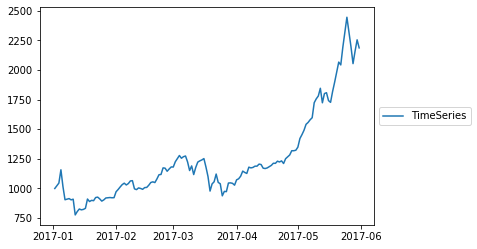

In [7]:
ts = TimeSeries(df_subset['Open']) # no future information
print(ts.describe())
ts.plot()

In [16]:
ma_strategy = MA(ts, 8, 21)

2017-01-25    True
2017-04-05    True
dtype: bool


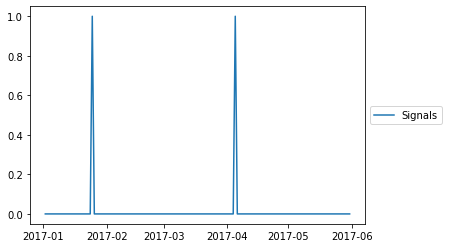

In [9]:
ma_entries = ma_strategy.entries().first()
print(ma_entries.non_empty())
ma_entries.plot()

2017-01-23    True
2017-03-15    True
dtype: bool


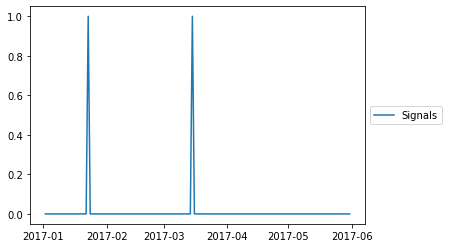

In [10]:
ma_exits = ma_strategy.exits().first()
print(ma_exits.non_empty())
ma_exits.plot()

In [17]:
tstop_strategy = TrailingStop(ts, ma_entries)

2017-03-11    True
2017-05-27    True
dtype: bool


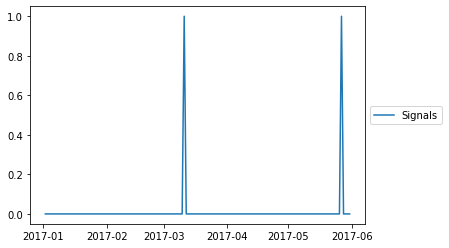

In [12]:
tstop_exits = tstop_strategy.exits(0.1)
print(tstop_exits.non_empty())
tstop_exits.plot()

2017-01-23    True
2017-03-11    True
2017-03-15    True
2017-05-27    True
dtype: bool


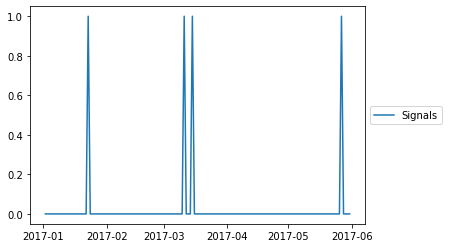

In [13]:
exits = ma_exits | tstop_exits
print(exits.non_empty())
exits.plot()

2017-01-25    1
2017-03-11   -1
2017-04-05    1
2017-05-27   -1
dtype: int64


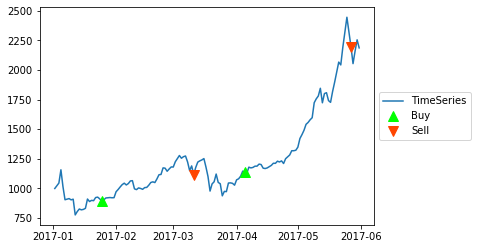

In [14]:
positions = Positions.from_signals(ma_entries, exits)
print(positions.non_empty())
positions.plot(ts)

In [15]:
# Fees and slippage
investment = 100
fees = 0.0025
slippage_factor = 0.25
slippage = TimeSeries(df_subset['High'] - df_subset['Low']) * slippage_factor / ts

In [18]:
portfolio = Portfolio(ts, positions, investment=investment, fees=fees, slippage=slippage)

In [19]:
# Portfolio when HODLing
hold_entries = Signals.empty(ts.shape, index=ts.index)
hold_entries[0] = True
hold_exits = Signals.empty(ts.shape, index=ts.index)
hold_positions = Positions.from_signals(hold_entries, hold_exits)
hold_portfolio = Portfolio(ts, hold_positions, investment=investment, fees=fees, slippage=slippage)

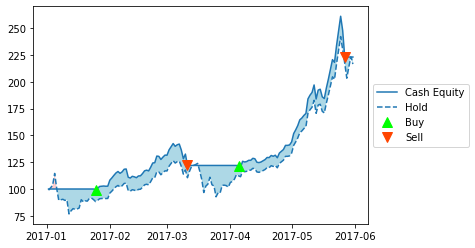

In [20]:
portfolio.cash_equity.plot(label='Cash Equity', 
                           benchmark=hold_portfolio.cash_equity, 
                           benchmark_label='Hold', 
                           positions=positions)

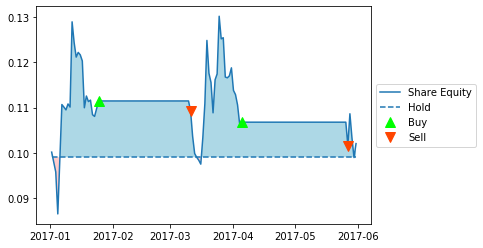

In [21]:
portfolio.share_equity.plot(label='Share Equity', 
                            benchmark=hold_portfolio.share_equity, 
                            benchmark_label='Hold', 
                            positions=positions)

In [22]:
portfolio.position_returns

TimeSeries([-0.0057321 ,  0.2267918 , -0.00721863,  0.84275271])